In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# -----------------------------
# Repro & Config
# -----------------------------
np.random.seed(42)
tf.random.set_seed(42)
CLASS_NAMES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


In [4]:
# -----------------------------
# Data
# -----------------------------

def load_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    y_train_cat = to_categorical(y_train, 10)
    y_test_cat = to_categorical(y_test, 10)
    return (x_train, y_train, y_train_cat), (x_test, y_test, y_test_cat)


In [5]:
# -----------------------------
# Xception-style building blocks
# -----------------------------

def bn_act(x):
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


In [6]:
def xception_block(x, filters, stride=1):
    """
    Minimal Xception-style block: pre-activation + two SeparableConv2D layers (no non-linearity
    between depthwise and pointwise convs inside each SeparableConv2D), with residual.
    The second SeparableConv2D may downsample via 'stride'.
    """
    # Residual path
    residual = x
    if stride != 1 or residual.shape[-1] != filters:
        residual = layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(residual)
        residual = layers.BatchNormalization()(residual)

    # Main path (pre-activation style)
    x = bn_act(x)
    x = layers.SeparableConv2D(filters, 3, padding='same', use_bias=False)(x)
    x = bn_act(x)
    x = layers.SeparableConv2D(filters, 3, strides=stride, padding='same', use_bias=False)(x)

    x = layers.Add()([x, residual])
    return x


In [7]:
def build_xception_one_block(width_mult=1.0):
    inputs = layers.Input(shape=(32, 32, 3))

    # Stem
    f1 = int(32 * width_mult)
    x = layers.Conv2D(f1, 3, strides=1, padding='same', use_bias=False)(inputs)
    x = bn_act(x)

    # Single Xception block (downsampling to aggregate)
    f2 = int(64 * width_mult)
    x = xception_block(x, filters=f2, stride=2)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs, name=f"xception_one_block_w{width_mult}")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [8]:
# -----------------------------
# Training + Visualizations
# -----------------------------

def plot_history(history):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Epochs'); plt.legend(); plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epochs'); plt.legend(); plt.grid(True)
    plt.show()


In [9]:
def plot_confusion(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
    plt.tight_layout(); plt.show()


In [10]:
def show_sample_predictions(x, y_true, y_pred, class_names, n=12):
    idxs = np.random.choice(len(x), size=n, replace=False)
    cols = 6
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(2.1*cols, 2.4*rows))
    for i, idx in enumerate(idxs):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(x[idx])
        t = class_names[int(y_true[idx])]
        p = class_names[int(y_pred[idx])]
        ax.set_title(f"T:{t}\nP:{p}", fontsize=9)
        ax.axis('off')
    plt.suptitle('Random Test Samples: True vs Predicted', y=1.02)
    plt.tight_layout(); plt.show()



In [11]:
def summarize_params(model):
    total = model.count_params()
    sep_dw_params = 0
    sep_pw_params = 0
    conv_params = 0

    for l in model.layers:
        if isinstance(l, layers.SeparableConv2D):
            # weights: depthwise_kernel (k,k,in,dm), pointwise_kernel (1,1,in*dm,out)
            for w in l.weights:
                s = np.prod(w.shape)
                # Heuristic: depthwise kernels are 3D (k,k,in) or 4D with small out (depth_multiplier)
                if 'depthwise_kernel' in w.name:
                    sep_dw_params += s
                elif 'pointwise_kernel' in w.name:
                    sep_pw_params += s
        elif isinstance(l, layers.Conv2D):
            conv_params += l.count_params()

    print("\nParameter Breakdown:")
    print(f"Total params: {total:,}")
    print(f"Separable depthwise params: {int(sep_dw_params):,}")
    print(f"Separable pointwise params: {int(sep_pw_params):,}")
    print(f"Standard Conv2D params: {int(conv_params):,}")


In [13]:
# -----------------------------
# Grad-CAM (for last SeparableConv2D layer)
# -----------------------------

def grad_cam(model, images, class_indices=None, overlay=True):
    # Find last separable conv layer
    last_conv = None
    for l in reversed(model.layers):
        if isinstance(l, layers.SeparableConv2D):
            last_conv = l
            break
    if last_conv is None:
        raise ValueError("No SeparableConv2D layer found for Grad-CAM.")

    grad_model = tf.keras.models.Model([model.inputs], [last_conv.output, model.output])

    heatmaps = []
    preds = model.predict(images, verbose=0)
    if class_indices is None:
        class_indices = np.argmax(preds, axis=1)

    for i in range(len(images)):
        img = images[i:i+1]
        class_idx = int(class_indices[i])
        with tf.GradientTape() as tape:
            conv_out, preds_out = grad_model(img)
            loss = preds_out[:, class_idx]
        grads = tape.gradient(loss, conv_out)  # (1, h, w, c)
        pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
        conv_out = conv_out[0]
        heatmap = tf.reduce_sum(tf.multiply(conv_out, pooled_grads), axis=-1)
        heatmap = tf.nn.relu(heatmap)
        heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
        heatmaps.append(heatmap.numpy())

    # Plot a few
    n = min(6, len(images))
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f"Image {i+1}")

        plt.subplot(2, n, n+i+1)
        hm = heatmaps[i]
        hm = np.uint8(255 * hm)
        hm = np.stack([hm]*3, axis=-1)
        hm = tf.image.resize(tf.cast(hm, tf.float32), [images[i].shape[0], images[i].shape[1]]).numpy().astype(np.uint8)
        if overlay:
            over = (0.6*images[i] + 0.4*(hm/255.0)).clip(0,1)
            plt.imshow(over)
        else:
            plt.imshow(hm)
        plt.axis('off')
        plt.title('Grad-CAM')
    plt.tight_layout(); plt.show()


In [14]:

# -----------------------------
# Inspect depthwise kernels & feature maps
# -----------------------------

def visualize_depthwise_kernels(model, max_channels=8):
    sep = None
    for l in model.layers:
        if isinstance(l, layers.SeparableConv2D):
            sep = l
            break
    if sep is None:
        print("No SeparableConv2D found.")
        return
    weights = sep.get_weights()
    if len(weights) == 0:
        print("Layer weights not initialized yet.")
        return
    depthwise_k = weights[0]  # (k, k, in_ch, depth_mult)
    k, _, in_ch, dm = depthwise_k.shape
    dm_idx = 0
    ch_to_show = min(max_channels, in_ch)
    cols = ch_to_show
    rows = 1
    plt.figure(figsize=(2*cols, 2.2*rows))
    for i in range(ch_to_show):
        ax = plt.subplot(rows, cols, i+1)
        kernel_2d = depthwise_k[:,:,i,dm_idx]
        im = ax.imshow(kernel_2d, cmap='coolwarm')
        ax.set_title(f"Ch {i}")
        ax.axis('off')
    plt.suptitle('Depthwise 3x3 Kernels (first SeparableConv2D)')
    plt.tight_layout(); plt.show()


In [15]:
def visualize_feature_maps(model, x_sample, layer_index=None, max_maps=8):
    # Choose the first SeparableConv2D if no index provided
    target_layer = None
    if layer_index is not None and isinstance(model.layers[layer_index], layers.SeparableConv2D):
        target_layer = model.layers[layer_index]
    else:
        for l in model.layers:
            if isinstance(l, layers.SeparableConv2D):
                target_layer = l
                break
    if target_layer is None:
        print("No SeparableConv2D found.")
        return
    fmap_model = tf.keras.Model(inputs=model.inputs, outputs=target_layer.output)
    fmap = fmap_model.predict(x_sample[None, ...], verbose=0)[0]  # (H,W,C)
    c = min(max_maps, fmap.shape[-1])
    cols = c
    rows = 1
    plt.figure(figsize=(2*cols, 2.2*rows))
    for i in range(c):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(fmap[:,:,i], cmap='viridis')
        ax.axis('off')
        ax.set_title(f"FM {i}")
    plt.suptitle('Feature Maps (first SeparableConv2D)')
    plt.tight_layout(); plt.show()

Model: "xception_one_block_w1.0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ re_lu_3[0][0]     │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 32, 32,    │      2,336 │ re_lu_4[0][0]     │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │      2,048 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_3  │ (None, 16, 16,    │      4,672 │ re_lu_5[0][0]     │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 16, 16,    │          0 │ separable_conv2d… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │        650 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,338 (44.29 KB)

 Trainable params: 10,954 (42.79 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.2752 - loss: 1.9743 - val_accuracy: 0.1231 - val_loss: 2.8420
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4327 - loss: 1.5643 - val_accuracy: 0.4384 - val_loss: 1.5345
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4775 - loss: 1.4576 - val_accuracy: 0.4410 - val_loss: 1.5499
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5012 - loss: 1.4034 - val_accuracy: 0.4399 - val_loss: 1.6297
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5150 - loss: 1.3671 - val_accuracy: 0.3869 - val_loss: 1.7743


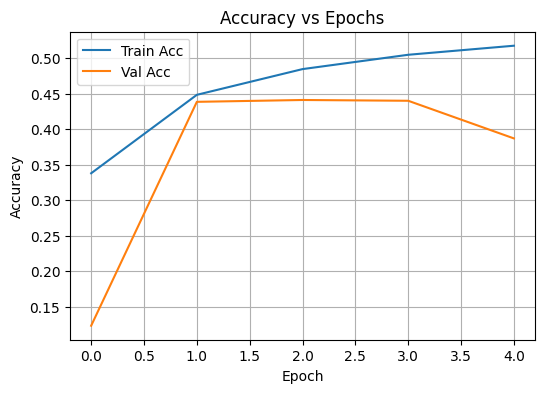

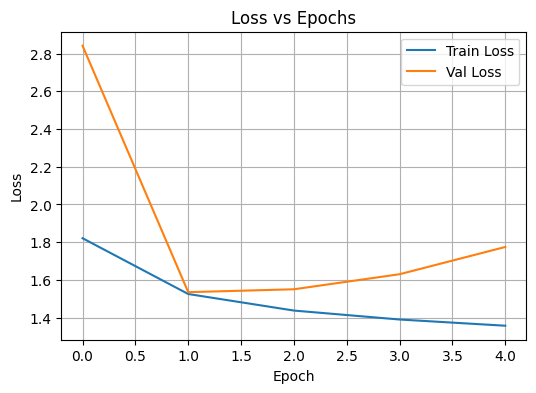


Test Accuracy: 0.3886

Classification Report:

              precision    recall  f1-score   support

    airplane       0.58      0.45      0.51      1000
  automobile       0.68      0.30      0.42      1000
        bird       0.45      0.16      0.23      1000
         cat       0.66      0.02      0.04      1000
        deer       0.30      0.53      0.39      1000
         dog       0.61      0.07      0.13      1000
        frog       0.64      0.51      0.57      1000
       horse       0.23      0.88      0.37      1000
        ship       0.75      0.32      0.45      1000
       truck       0.43      0.64      0.51      1000

    accuracy                           0.39     10000
   macro avg       0.53      0.39      0.36     10000
weighted avg       0.53      0.39      0.36     10000



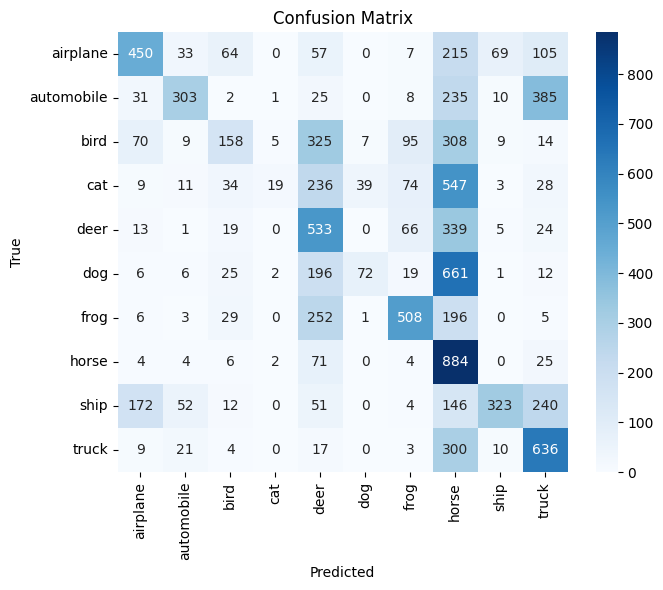

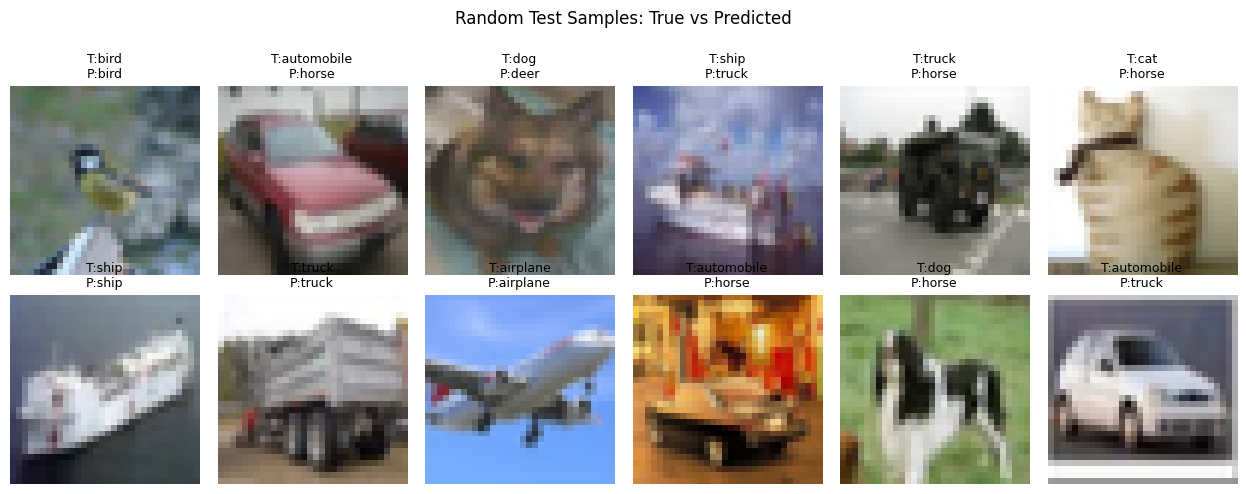


Parameter Breakdown:
Total params: 11,338
Separable depthwise params: 864
Separable pointwise params: 6,144
Standard Conv2D params: 2,912


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_15']]
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


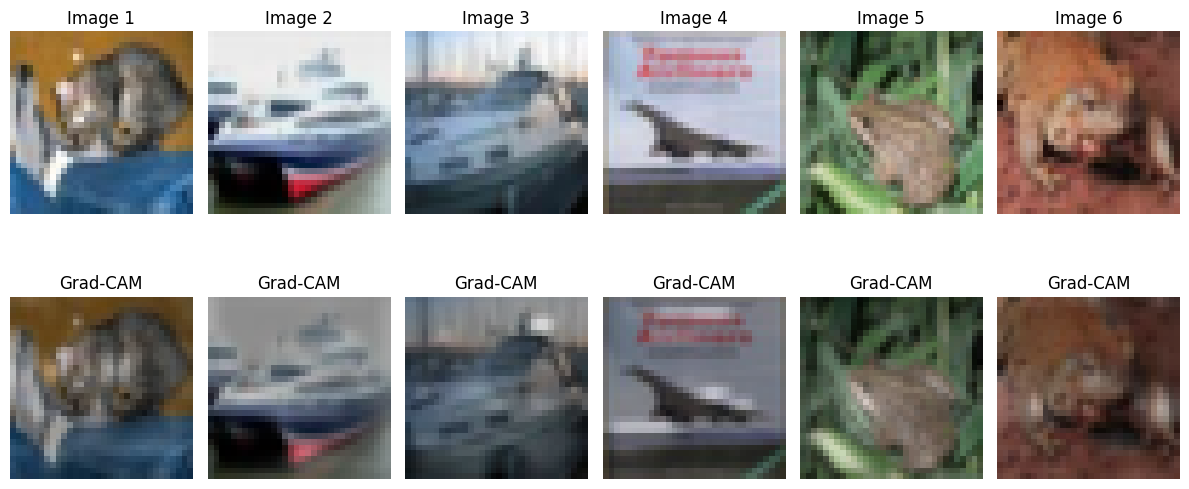

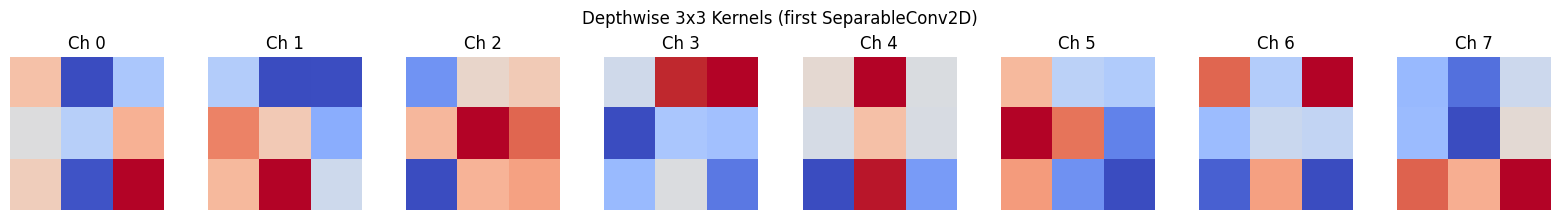

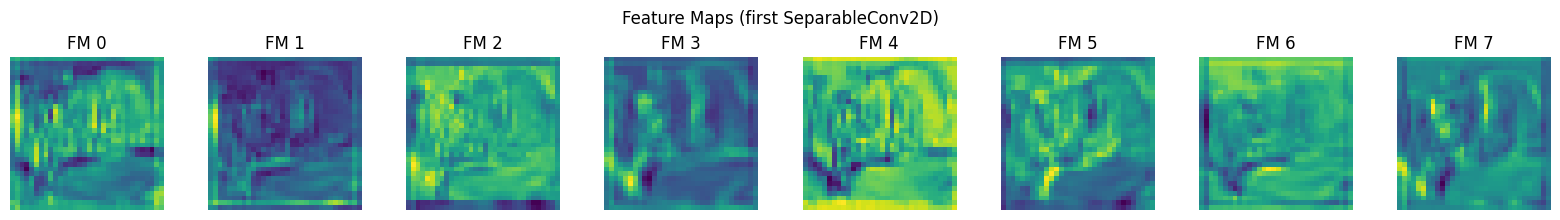

In [16]:

# -----------------------------
# Run end-to-end (5 epochs)
# -----------------------------

if __name__ == "__main__":
    (x_train, y_train, y_train_cat), (x_test, y_test, y_test_cat) = load_data()

    model = build_xception_one_block(width_mult=1.0)
    model.summary()

    history = model.fit(
        x_train, y_train_cat,
        validation_split=0.2,
        epochs=5,
        batch_size=128,
        verbose=1
    )

    plot_history(history)

    # Evaluate & predictions
    test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
    print(f"\nTest Accuracy: {test_acc:.4f}")

    y_probs = model.predict(x_test, verbose=0)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = y_test.flatten()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    plot_confusion(y_true, y_pred, CLASS_NAMES)
    show_sample_predictions(x_test, y_true, y_pred, CLASS_NAMES, n=12)

    summarize_params(model)

    # Grad-CAM on a handful of test images
    grad_cam(model, x_test[:6])

    # Inspect weights & features
    visualize_depthwise_kernels(model, max_channels=8)
    visualize_feature_maps(model, x_test[0], max_maps=8)
